# Temperature Forecasting (Supplementary Notebook)

Similar to what was done in previous sections, this notebook applies the methodology used in the M5 Forecasting notebook to the Jena Climate dataset. Specifically, we will be forecasting the temperature variable.

Prepared by: Sebastian C. Ibañez


## 1. Jena Climate Dataset

Let's load the dataset and examine it.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

plt.rcParams['figure.figsize'] = [15, 5]

np.set_printoptions(precision = 6, suppress = True)

df = pd.read_csv('../data/jena_climate_2009_2016.csv')

In [3]:
df.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


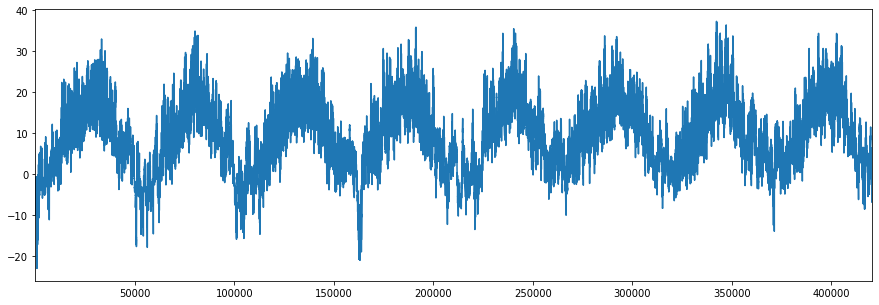

(420546,)


In [4]:
series = df['T (degC)'].iloc[5:]

series.plot()
plt.show()
print(series.shape)

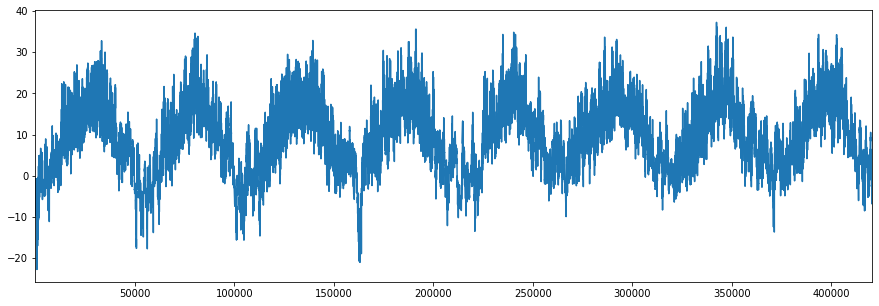

(70091,)


In [5]:
series = series.iloc[::6]

series.plot()
plt.show()
print(series.shape)

In [6]:
### HYPERPARAMETERS ###
window_size = 240
prediction_horizon = 1

### TRAIN TEST VAL SPLIT ###
train_series = series[:35045]
val_series = series[35045:52569]
test_series = series[52569:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
val_x, val_y = create_xy(val_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
val_y = val_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

KeyError: 0

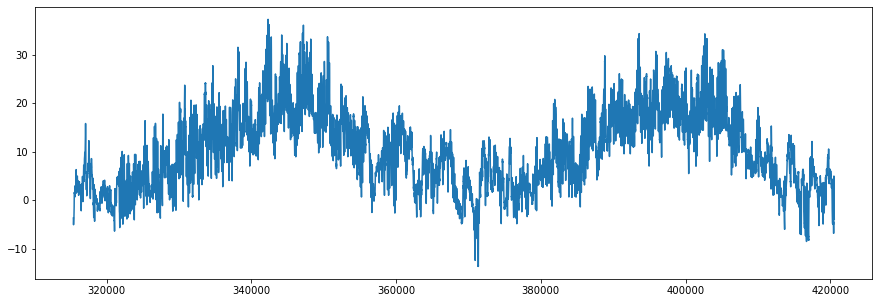

In [38]:
test_series.plot()
plt.show()

###  LightGBM

In [39]:
import lightgbm as lgb

model = lgb.LGBMRegressor()

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(val_x, val_y)],
          early_stopping_rounds = 100,
          verbose = 0)

LGBMRegressor()

In [40]:
forecast = model.predict(test_x)
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

#series[-test_size:].plot(marker = 'o', linestyle = '--')
#plt.plot(forecast, marker = 'o', linestyle = '--')
#plt.show()

  LightGBM MAE: 0.5256


In [41]:
### HYPERPARAMETERS ###
window_size = 240
prediction_horizon = 24

### TRAIN VAL TEST SPLIT ###
train_series = series[:35045]
val_series = series[35045:52569]
test_series = series[52569:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
val_x, val_y = create_xy(val_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(34782, 240)
(34782, 24)
(17261, 240)
(17261, 24)
(17259, 240)
(17259, 24)


In [68]:
recursive_x = test_x
forecast_ms = []
for j in range(prediction_horizon):
    pred = model.predict(recursive_x)
    recursive_x = np.hstack((recursive_x[:, 1:], pred[:, np.newaxis]))
    forecast_ms.append(pred)
forecast_ms = np.asarray(forecast_ms).T
print(np.mean(np.abs(test_y - forecast_ms)))

2.0830415023892113


## Summary

Using LightGBM with a recursive forecasting strategy demonstrates that we can achieve an MAE of about 2.08°C without hyperparameter tuning.